In [1]:
from torch.utils.data import DataLoader
from attrbench.lib import PixelMaskingPolicy
from attrbench.evaluation import independent
from experiments.lib.util import get_ds_model, get_methods, get_n_pixels
from experiments.lib import attribution
import torch
from tqdm import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from captum import attr

In [2]:
ds_name = "MNIST"
model_name = "CNN"
device = "cuda"
pmp = PixelMaskingPolicy(0.)
dataset, model = get_ds_model(ds_name, model_name)
model.to(device)
model.eval()
dl = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4)
rand = attribution.PixelAggregation(attribution.Random(), "avg")

n_pixels = get_n_pixels(ds_name)
step_size = int(0.02 * n_pixels)
mask_range = [step_size * i for i in range(25)]
pert_range = list(np.linspace(.01, 2., 20))

In [3]:
correctly_classified = []
infidelity = []
insertion = []
deletion = []
deletion_until_flip = []
ixg = attr.InputXGradient(model)
method = attribution.PixelAggregation(ixg.attribute, "avg")
#infid_method = attribution.DimReplication(method, 1, 3)
infid_method = method
for samples, labels in tqdm(dl):
    samples = samples.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        out = model(samples)
    predictions = torch.argmax(out, dim=1)
    correctly_classified.append((predictions == labels).cpu().detach().numpy())
    infidelity.append(independent.infidelity(samples, predictions, model, infid_method, perturbation_range=pert_range, num_perturbations=16).cpu().detach().numpy())
    insertion.append(independent.insertion_deletion(samples, predictions, model, method, mask_range, pmp, mode="insertion").cpu().detach().numpy())
    deletion.append(independent.insertion_deletion(samples, predictions, model, method, mask_range, pmp, mode="deletion").cpu().detach().numpy())
    deletion_until_flip.append(independent.deletion_until_flip(samples, predictions, model, method, pmp, step_size=.01).cpu().detach().numpy())

  0%|          | 0/79 [00:00<?, ?it/s]/home/arne/Documents/PhD/projects/benchmark/venv/lib/python3.8/site-packages/captum/attr/_utils/gradient.py:31: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
100%|██████████| 79/79 [06:07<00:00,  4.66s/it]


In [18]:
cc = np.concatenate(correctly_classified)

In [20]:
cc.sum()

9883

In [26]:
infid_cc = np.concatenate(infidelity)[cc]
infid_ncc = np.concatenate(infidelity)[~cc]

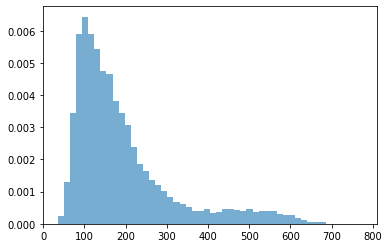

In [30]:
plt.hist(infid_cc.mean(axis=1).flatten(), bins=50, density=True, alpha=0.6)
pass

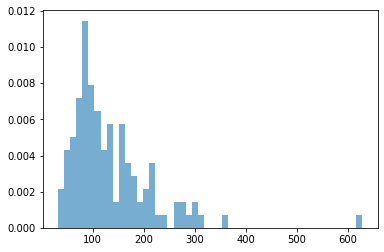

In [31]:
plt.hist(infid_ncc.mean(axis=1).flatten(), bins=50, density=True, alpha=0.6)
pass

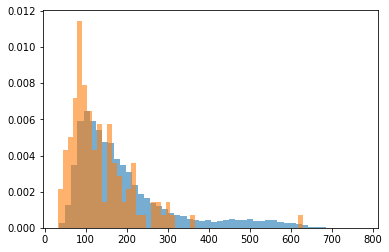

In [55]:
def plot_hists(data, cc):
    plt.hist(data[cc].mean(axis=1).flatten(), bins=50, density=True, alpha=0.6)
    plt.hist(data[~cc].mean(axis=1).flatten(), bins=50, density=True, alpha=0.6)
plot_hists(np.concatenate(infidelity), cc)

In [46]:
np.concatenate(deletion_until_flip).reshape(-1, 1).shape

(10000, 1)